# Try to get the Whitelight segmentation to acceptable levels
Specifically for TYC 70 or any other dataset

In [4]:
#I use cellpose env
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import cv2
# model_type='cyto' or 'nuclei' or 'cyto2' OR 'cyto3'
model = models.Cellpose(model_type='cyto')

from tifffile import imwrite
from matplotlib import image

import time
import cv2
from csbdeep.utils import normalize
import glob
from scipy import ndimage as ndi
from skimage import measure, morphology
from skimage.measure import regionprops, label

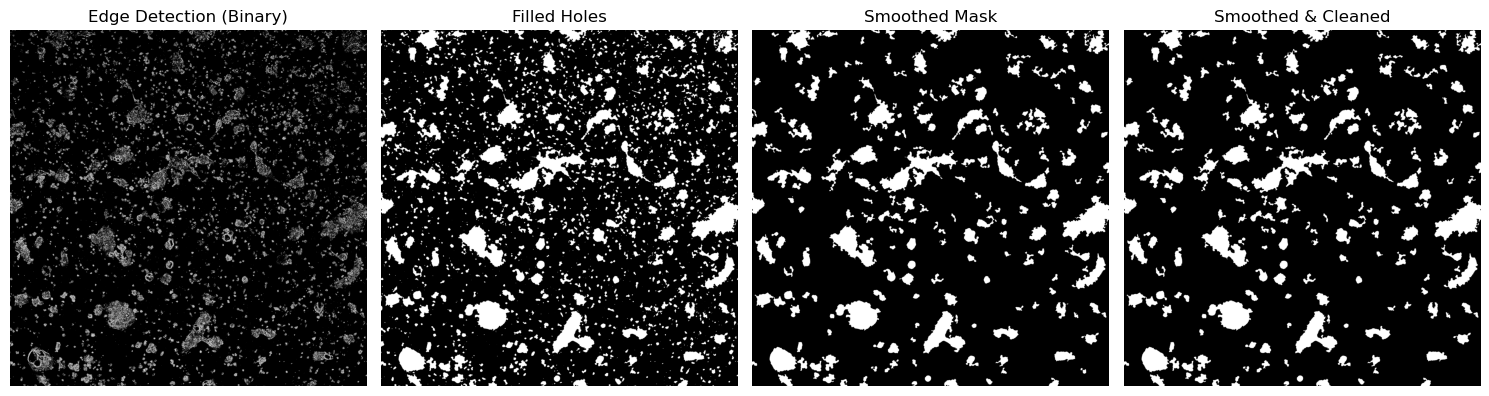

In [2]:
# Load image
path_to_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
WL_img = cv2.imread(path_to_file, -1)

# Edge detection (LoG)
WL_img_blurred = cv2.GaussianBlur(WL_img, (5, 5), 0)

# Step 2: Laplacian of Gaussian (LoG)
WL_img_edge = cv2.Laplacian(WL_img_blurred, cv2.CV_64F)
WL_img_edge_abs = np.abs(WL_img_edge)

# Step 3: Normalize edge image for visualization
WL_img_edge_norm = cv2.normalize(WL_img_edge_abs, None, 0, 255, cv2.NORM_MINMAX)
WL_img_edge_uint8 = np.uint8(WL_img_edge_norm)

# Step 4: Threshold using Otsu's method
_, WL_img_edge_bin = cv2.threshold(WL_img_edge_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 5: Morphological operations (closing and opening for smoother contours)
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # Larger kernel for more smoothing
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))

WL_img_dilated = cv2.dilate(WL_img_edge_bin, kernel_dilate)
WL_img_eroded = cv2.erode(WL_img_dilated, kernel_erode)

# Step 6: Fill holes
WL_img_filled = ndi.binary_fill_holes(WL_img_eroded > 0)

# Step 7: Remove small objects
WL_img_clean = morphology.remove_small_objects(WL_img_filled.astype(bool), min_size=3000)

# Step 8: Apply Gaussian Blur to smooth contours and round cells
WL_img_smooth = cv2.GaussianBlur(WL_img_clean.astype(np.uint8), (15, 15), 0)

# Step 9: Remove remaining small artifacts after smoothing
WL_img_smooth_cleaned = morphology.remove_small_objects(WL_img_smooth.astype(bool), min_size=3000)

# Label regions
L_filled = measure.label(WL_img_filled)
L = measure.label(WL_img_clean)
L_smooth = measure.label(WL_img_smooth_cleaned)

# Plotting the results
plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.imshow(WL_img_edge_bin, cmap='gray')
plt.title('Edge Detection (Binary)')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(WL_img_filled, cmap='gray')
plt.title('Filled Holes')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(WL_img_smooth, cmap='gray')
plt.title('Smoothed Mask')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(WL_img_smooth_cleaned, cmap='gray')
plt.title('Smoothed & Cleaned')
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\test\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17_4.tif"

cv2.imwrite(output_path, L_smooth)

True

## Cellpose segmentation

In [3]:
path_to_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
WL_img = cv2.imread(path_to_file, -1)

WL_img = cv2.GaussianBlur(WL_img, (15, 15), cv2.BORDER_DEFAULT)

WL_img = normalize(WL_img, 1, 75.0, axis=(0, 1))

channels = [0,0]

masks_small, flows, styles, diams = model.eval(WL_img, diameter = 40, channels=channels)       

# output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\test\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17_cellpose_50.tif"
# cv2.imwrite(output_path, masks_small)

In [42]:
# logic for 3 + 9 + 10
cellpose_mask = masks_small
cluster_mask = L_smooth

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

final_mask = np.zeros_like(cellpose_mask)
label_cp = label(cellpose_mask)
label_cl = label(cluster_mask)
props_cp = regionprops(label_cp)
props_cl = regionprops(label_cl)
used_clusters = set()
label_id = 1

for cp in props_cp:
    minr, minc, maxr, maxc = cp.bbox
    cp_mask = np.zeros_like(cellpose_mask)
    coords = cp.coords
    cp_mask[coords[:, 0], coords[:, 1]] = 1

    cluster_crop = label_cl[minr:maxr, minc:maxc]
    cp_crop = cp_mask[minr:maxr, minc:maxc]
    overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
    overlapping_ids = overlapping_ids[overlapping_ids > 0]

    if len(overlapping_ids) == 0:
        # No overlap with cluster → keep it
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1
    else:
        ious = []
        for oid in overlapping_ids:
            cl_coords = props_cl[oid - 1].coords
            cl_mask = np.zeros_like(cellpose_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1
            iou = compute_iou(cp_mask, cl_mask)
            ious.append(iou)

        if max(ious) < 0.4:
            # Grazing edge → keep Cellpose cell
            final_mask[coords[:, 0], coords[:, 1]] = label_id
            label_id += 1
        else:
            # Overlaps too much → merge Cellpose into the best-matching cluster
            best_match = overlapping_ids[np.argmax(ious)]
            cl_coords = props_cl[best_match - 1].coords
            cl_mask = np.zeros_like(final_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1

            # Merge Cellpose mask into the cluster mask
            final_mask[coords[:, 0], coords[:, 1]] = best_match  # merge CP into cluster ID

            used_clusters.add(best_match)  # Mark it as used

# Add untouched cluster regions
for cl in props_cl:
    if cl.label not in used_clusters:
        coords = cl.coords
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1


In [ ]:
# logic for 4 + 5 
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

final_mask = np.zeros_like(cellpose_mask)
label_cp = label(cellpose_mask)
label_cl = label(cluster_mask)
props_cp = regionprops(label_cp)
props_cl = regionprops(label_cl)
used_clusters = set()
label_id = 1

for cp in props_cp:
    minr, minc, maxr, maxc = cp.bbox
    cp_mask = np.zeros_like(cellpose_mask)
    coords = cp.coords
    cp_mask[coords[:, 0], coords[:, 1]] = 1

    cluster_crop = label_cl[minr:maxr, minc:maxc]
    cp_crop = cp_mask[minr:maxr, minc:maxc]
    overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
    overlapping_ids = overlapping_ids[overlapping_ids > 0]

    if len(overlapping_ids) == 0:
        # No overlap with cluster → keep it
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1
    else:
        ious = []
        for oid in overlapping_ids:
            cl_coords = props_cl[oid - 1].coords
            cl_mask = np.zeros_like(cellpose_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1
            iou = compute_iou(cp_mask, cl_mask)
            ious.append(iou)

        max_iou = max(ious)
        best_match = overlapping_ids[np.argmax(ious)]

        if max_iou < 0.3:
            # Check residual shape to see if it's just noise or part of cluster
            cl_coords = props_cl[best_match - 1].coords
            cl_mask = np.zeros_like(cellpose_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1

            # Residual = CP mask minus cluster overlap
            residual_mask = np.logical_and(cp_mask, np.logical_not(cl_mask))

            residual_labeled = label(residual_mask)
            residual_props = regionprops(residual_labeled)

            if len(residual_props) == 0:
                merge_into_cluster = True
            else:
                r = residual_props[0]
                area = r.area
                perimeter = r.perimeter if r.perimeter > 0 else 1
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                solidity = r.solidity

                # Heuristic thresholds — tweak as needed
                if area < 300 or circularity < 0.5 or solidity < 0.7:
                    merge_into_cluster = True
                else:
                    merge_into_cluster = False

            if merge_into_cluster:
                final_mask[coords[:, 0], coords[:, 1]] = best_match
                used_clusters.add(best_match)
            else:
                final_mask[coords[:, 0], coords[:, 1]] = label_id
                label_id += 1
        else:
            # Overlaps a lot → merge into cluster
            final_mask[coords[:, 0], coords[:, 1]] = best_match
            used_clusters.add(best_match)

# Add untouched cluster regions
for cl in props_cl:
    if cl.label not in used_clusters:
        coords = cl.coords
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1

In [ ]:
# logic for 6 
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

final_mask = np.zeros_like(cellpose_mask)
label_cp = label(cellpose_mask)
label_cl = label(cluster_mask)
props_cp = regionprops(label_cp)
props_cl = regionprops(label_cl)
used_clusters = set()
label_id = 1

# Helper to get binary mask
def get_binary_mask(shape, coords):
    mask = np.zeros(shape, dtype=np.uint8)
    mask[coords[:, 0], coords[:, 1]] = 1
    return mask

# Iterate through Cellpose cells first (to avoid overwriting small cells)
for cp in props_cp:
    cp_mask = get_binary_mask(cellpose_mask.shape, cp.coords)
    minr, minc, maxr, maxc = cp.bbox
    cluster_crop = label_cl[minr:maxr, minc:maxc]
    cp_crop = cp_mask[minr:maxr, minc:maxc]
    overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
    overlapping_ids = overlapping_ids[overlapping_ids > 0]

    if len(overlapping_ids) == 0:
        # No overlap with any cluster → keep it as a new cell
        final_mask[cp_mask > 0] = label_id
        label_id += 1
    else:
        ious = []
        for oid in overlapping_ids:
            cl = props_cl[oid - 1]
            cl_mask = get_binary_mask(cellpose_mask.shape, cl.coords)
            iou = compute_iou(cp_mask, cl_mask)
            ious.append(iou)

        max_iou = max(ious)
        best_match = overlapping_ids[np.argmax(ious)]

        if max_iou < 0.3:
            # Check residual shape to see if it's just noise or part of cluster
            cl = props_cl[best_match - 1]
            cl_mask = get_binary_mask(cellpose_mask.shape, cl.coords)

            # Residual = CP mask minus cluster overlap
            residual_mask = np.logical_and(cp_mask, np.logical_not(cl_mask))
            residual_labeled = label(residual_mask)
            residual_props = regionprops(residual_labeled)

            if len(residual_props) == 0:
                # Residual is small → merge into cluster
                final_mask[cp_mask > 0] = best_match
                used_clusters.add(best_match)
            else:
                r = residual_props[0]
                area = r.area
                perimeter = r.perimeter if r.perimeter > 0 else 1
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                solidity = r.solidity

                # Heuristic thresholds — tweak as needed
                if area < 300 or circularity < 0.5 or solidity < 0.7:
                    final_mask[cp_mask > 0] = best_match
                    used_clusters.add(best_match)
                else:
                    # Residual doesn't fit → keep as new cell
                    final_mask[cp_mask > 0] = label_id
                    label_id += 1
        else:
            # Overlaps enough → merge into cluster
            final_mask[cp_mask > 0] = best_match
            used_clusters.add(best_match)

# Add untouched cluster regions (clusters that didn't get merged)
for cl in props_cl:
    if cl.label not in used_clusters:
        cl_mask = get_binary_mask(cellpose_mask.shape, cl.coords)
        final_mask[cl_mask > 0] = label_id
        label_id += 1

In [21]:
# logic for 7 + 8
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

final_mask = np.zeros_like(cellpose_mask)
label_cp = label(cellpose_mask)
label_cl = label(cluster_mask)
props_cp = regionprops(label_cp)
props_cl = regionprops(label_cl)
used_clusters = set()
label_id = 1

for cp in props_cp:
    minr, minc, maxr, maxc = cp.bbox
    cp_mask = np.zeros_like(cellpose_mask)
    coords = cp.coords
    cp_mask[coords[:, 0], coords[:, 1]] = 1

    cluster_crop = label_cl[minr:maxr, minc:maxc]
    cp_crop = cp_mask[minr:maxr, minc:maxc]
    overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
    overlapping_ids = overlapping_ids[overlapping_ids > 0]

    if len(overlapping_ids) == 0:
        # No overlap with cluster → keep it
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1
    else:
        ious = []
        for oid in overlapping_ids:
            cl_coords = props_cl[oid - 1].coords
            cl_mask = np.zeros_like(cellpose_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1
            iou = compute_iou(cp_mask, cl_mask)
            ious.append(iou)

        max_iou = max(ious)
        best_match = overlapping_ids[np.argmax(ious)]

        if max_iou < 0.3:
            # Grazing edge → analyze residual part of CP cell
            cl_coords = props_cl[best_match - 1].coords
            cl_mask = np.zeros_like(cellpose_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1

            residual_mask = np.logical_and(cp_mask, np.logical_not(cl_mask))
            residual_labeled = label(residual_mask)
            residual_props = regionprops(residual_labeled)

            if len(residual_props) == 0:
                merge_into_cluster = True
            else:
                r = residual_props[0]
                area = r.area
                perimeter = r.perimeter if r.perimeter > 0 else 1
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                solidity = r.solidity

                # Heuristic thresholds — tweak as needed
                if area < 300 or circularity < 0.5 or solidity < 0.7:
                    merge_into_cluster = True
                else:
                    merge_into_cluster = False

            if merge_into_cluster:
                final_mask[coords[:, 0], coords[:, 1]] = best_match
                used_clusters.add(best_match)
            else:
                final_mask[coords[:, 0], coords[:, 1]] = label_id
                label_id += 1

        else:
            # Overlaps too much → merge Cellpose into the best-matching cluster
            final_mask[coords[:, 0], coords[:, 1]] = best_match
            used_clusters.add(best_match)

# Add untouched cluster regions
for cl in props_cl:
    if cl.label not in used_clusters:
        coords = cl.coords
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1

In [35]:
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\test\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17_combined_better10.tif"
cv2.imwrite(output_path, final_mask)

True

## Combining membrane segmentation with WL segmentation

In [ ]:
# 1 to 3
from skimage.morphology import remove_small_objects
path_to_membrane = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS\72hr_recording_50B_2000ms_frame00000_ROI17.tif"
membrane_mask = cv2.imread(path_to_membrane, -1)

membrane_mask = membrane_mask.astype(np.int32)
final_mask = final_mask.astype(np.int32)

combined_mem_WL = (final_mask * 10000) + membrane_mask

relabeled_mem_WL = label(combined_mem_WL)

min_size = 300
cleaned = remove_small_objects(relabeled_mem_WL, min_size=min_size)

final_mem_WL = label(cleaned)

In [ ]:
# 4
# Ensure proper dtype
final_mask = final_mask.astype(np.int32)
membrane_mask = membrane_mask.astype(np.int32)

# Identify overlap
overlap = (final_mask > 0) & (membrane_mask > 0)
wl_only = (final_mask > 0) & (membrane_mask == 0)
membrane_only = (membrane_mask > 0) & (final_mask == 0)

# Build combined mask with priorities (e.g., membrane preferred for singles)
combined = np.zeros_like(final_mask)
combined[wl_only] = final_mask[wl_only]
combined[membrane_only] = membrane_mask[membrane_only] + final_mask.max()  # avoid label collision
combined[overlap] = final_mask[overlap]  # or choose membrane_mask here if preferred

# Remove small objects
min_size = 500
cleaned = remove_small_objects(combined, min_size=min_size)

# Relabel for final output
final_mem_WL = label(cleaned)

In [54]:
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\test\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17_combined_mem4.tif"
cv2.imwrite(output_path, final_mem_WL)

True

## Accuracy check

Total nuclei: 1990
Nuclei inside WL mask: 1816
Nuclei missed: 174
Coverage: 91.26%


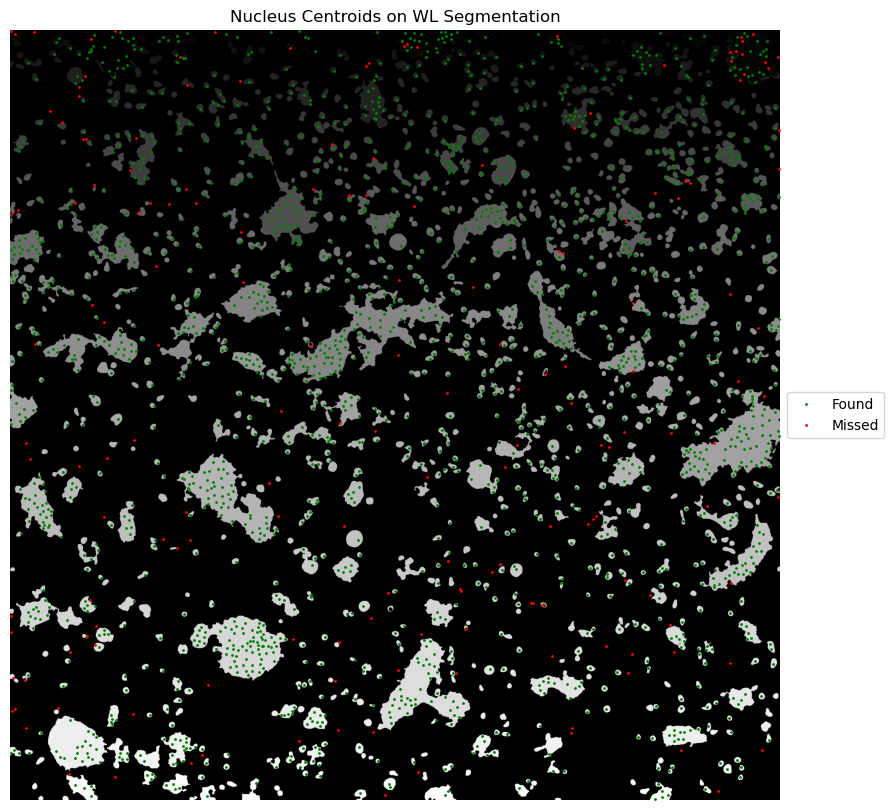

In [55]:


# Load and label the nucleus mask
nucleus_mask_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_ImgGS\72hr_recording_50R_2500ms_frame00000_ROI17.tif"
nucleus_mask_img = cv2.imread(nucleus_mask_file, -1)
labeled_mask_nucleus = label(nucleus_mask_img)
props_nucleus = regionprops(labeled_mask_nucleus)

# Get centroids
centroids = [prop.centroid for prop in props_nucleus]

# Sort centroids into found / missed
found_points = []
missed_points = []

for y, x in centroids:
    y_int, x_int = int(round(y)), int(round(x))
    if 0 <= y_int < final_mem_WL.shape[0] and 0 <= x_int < final_mem_WL.shape[1]:
        if final_mem_WL[y_int, x_int]:
            found_points.append((x, y))  # Note: plot uses (x, y)
        else:
            missed_points.append((x, y))

# Convert to arrays for easy plotting
found_points = np.array(found_points)
missed_points = np.array(missed_points)

# 5. Output
print(f"Total nuclei: {len(centroids)}")
print(f"Nuclei inside WL mask: {len(found_points)}")
print(f"Nuclei missed: {len(missed_points)}")
print(f"Coverage: {100 * len(found_points) / len(centroids):.2f}%")

# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(final_mem_WL, cmap='gray')
if len(found_points) > 0:
    plt.plot(found_points[:, 0], found_points[:, 1], 'go', markersize=1, label='Found')
if len(missed_points) > 0:
    plt.plot(missed_points[:, 0], missed_points[:, 1], 'ro', markersize=1, label='Missed')
plt.title("Nucleus Centroids on WL Segmentation")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('off')
plt.show()


Total WL segments: 1574
WL segments overlapping with nucleus: 653
WL segments without nucleus: 921
Coverage: 41.49%


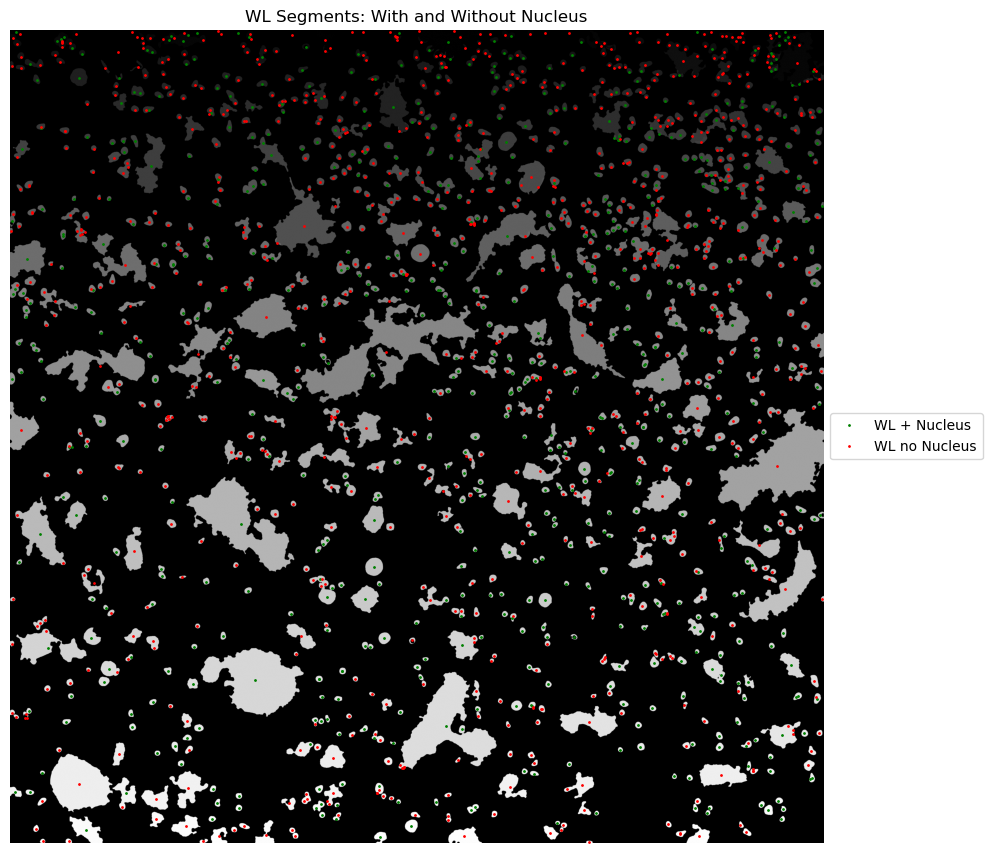

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label

# Load and label the nucleus mask
nucleus_mask_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_ImgGS\72hr_recording_50R_2500ms_frame00000_ROI17.tif"
nucleus_mask_img = cv2.imread(nucleus_mask_file, -1)
nucleus_mask_binary = nucleus_mask_img > 0
labeled_nucleus = label(nucleus_mask_binary)

# Load the WL image used for segmentation (for background)
WL_img_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
WL_img = cv2.imread(WL_img_file, -1)

# Label WL segmentation mask
labeled_WL = label(final_mem_WL)
props_WL = regionprops(labeled_WL)

# Get WL centroids
centroids_WL = [prop.centroid for prop in props_WL]

# Check if WL-segmented cells overlap with any nucleus
found_WL = []
missed_WL = []

for y, x in centroids_WL:
    y_int, x_int = int(round(y)), int(round(x))
    if 0 <= y_int < nucleus_mask_binary.shape[0] and 0 <= x_int < nucleus_mask_binary.shape[1]:
        if nucleus_mask_binary[y_int, x_int]:
            found_WL.append((x, y))  # x, y for plotting
        else:
            missed_WL.append((x, y))

# Convert to arrays for easy plotting
found_WL = np.array(found_WL)
missed_WL = np.array(missed_WL)

# Print stats
print(f"Total WL segments: {len(centroids_WL)}")
print(f"WL segments overlapping with nucleus: {len(found_WL)}")
print(f"WL segments without nucleus: {len(missed_WL)}")
print(f"Coverage: {100 * len(found_WL) / len(centroids_WL):.2f}%")

# --- Plotting ---
plt.figure(figsize=(10, 10))
plt.imshow(final_mem_WL, cmap='gray')  # Show grayscale WL image as background

if len(found_WL) > 0:
    plt.plot(found_WL[:, 0], found_WL[:, 1], 'go', markersize=1, label='WL + Nucleus')
if len(missed_WL) > 0:
    plt.plot(missed_WL[:, 0], missed_WL[:, 1], 'ro', markersize=1, label='WL no Nucleus')

plt.title("WL Segments: With and Without Nucleus")
plt.axis('off')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [45]:
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\test\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17_combined_what.tif"
cv2.imwrite(output_path, combined_mask)

True

## Complete segmentation code

In [ ]:
# Load image
path_to_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
WL_img = cv2.imread(path_to_file, -1)

# Edge detection (LoG)
WL_img_blurred = cv2.GaussianBlur(WL_img, (5, 5), 0)

# Step 2: Laplacian of Gaussian (LoG)
WL_img_edge = cv2.Laplacian(WL_img_blurred, cv2.CV_64F)
WL_img_edge_abs = np.abs(WL_img_edge)

# Step 3: Normalize edge image for visualization
WL_img_edge_norm = cv2.normalize(WL_img_edge_abs, None, 0, 255, cv2.NORM_MINMAX)
WL_img_edge_uint8 = np.uint8(WL_img_edge_norm)

# Step 4: Threshold using Otsu's method
_, WL_img_edge_bin = cv2.threshold(WL_img_edge_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 5: Morphological operations (closing and opening for smoother contours)
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))

WL_img_dilated = cv2.dilate(WL_img_edge_bin, kernel_dilate)
WL_img_eroded = cv2.erode(WL_img_dilated, kernel_erode)

# Step 6: Fill holes
WL_img_filled = ndi.binary_fill_holes(WL_img_eroded > 0)

# Step 7: Remove small objects
WL_img_clean = morphology.remove_small_objects(WL_img_filled.astype(bool), min_size=3000)

# Step 8: Apply Gaussian Blur to smooth contours and round cells
WL_img_smooth = cv2.GaussianBlur(WL_img_clean.astype(np.uint8), (15, 15), 0)

# Step 9: Remove remaining small artifacts after smoothing
WL_img_smooth_cleaned = morphology.remove_small_objects(WL_img_smooth.astype(bool), min_size=3000)

# Label regions
L_filled = measure.label(WL_img_filled)
L = measure.label(WL_img_clean)
L_smooth = measure.label(WL_img_smooth_cleaned)

path_to_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
WL_img = cv2.imread(path_to_file, -1)

WL_img = cv2.GaussianBlur(WL_img, (15, 15), cv2.BORDER_DEFAULT)

WL_img = normalize(WL_img, 1, 75.0, axis=(0, 1))

channels = [0,0]

masks_small, flows, styles, diams = model.eval(WL_img, diameter = 40, channels=channels)


cellpose_mask = masks_small
cluster_mask = L_smooth

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

final_mask = np.zeros_like(cellpose_mask)
label_cp = label(cellpose_mask)
label_cl = label(cluster_mask)
props_cp = regionprops(label_cp)
props_cl = regionprops(label_cl)
used_clusters = set()
label_id = 1

for cp in props_cp:
    minr, minc, maxr, maxc = cp.bbox
    cp_mask = np.zeros_like(cellpose_mask)
    coords = cp.coords
    cp_mask[coords[:, 0], coords[:, 1]] = 1

    cluster_crop = label_cl[minr:maxr, minc:maxc]
    cp_crop = cp_mask[minr:maxr, minc:maxc]
    overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
    overlapping_ids = overlapping_ids[overlapping_ids > 0]

    if len(overlapping_ids) == 0:
        # No overlap with cluster → keep it
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1
    else:
        ious = []
        for oid in overlapping_ids:
            cl_coords = props_cl[oid - 1].coords
            cl_mask = np.zeros_like(cellpose_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1
            iou = compute_iou(cp_mask, cl_mask)
            ious.append(iou)

        if max(ious) < 0.4:
            # Grazing edge → keep Cellpose cell
            final_mask[coords[:, 0], coords[:, 1]] = label_id
            label_id += 1
        else:
            # Overlaps too much → merge Cellpose into the best-matching cluster
            best_match = overlapping_ids[np.argmax(ious)]
            cl_coords = props_cl[best_match - 1].coords
            cl_mask = np.zeros_like(final_mask)
            cl_mask[cl_coords[:, 0], cl_coords[:, 1]] = 1

            # Merge Cellpose mask into the cluster mask
            final_mask[coords[:, 0], coords[:, 1]] = best_match  # merge CP into cluster ID

            used_clusters.add(best_match)  # Mark it as used

# Add untouched cluster regions
for cl in props_cl:
    if cl.label not in used_clusters:
        coords = cl.coords
        final_mask[coords[:, 0], coords[:, 1]] = label_id
        label_id += 1

path_to_membrane = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS\72hr_recording_50B_2000ms_frame00000_ROI17.tif"
membrane_mask = cv2.imread(path_to_membrane, -1)

# Ensure proper dtype
final_mask = final_mask.astype(np.int32)
membrane_mask = membrane_mask.astype(np.int32)

# Identify overlap
overlap = (final_mask > 0) & (membrane_mask > 0)
wl_only = (final_mask > 0) & (membrane_mask == 0)
membrane_only = (membrane_mask > 0) & (final_mask == 0)

# Build combined mask with priorities (e.g., membrane preferred for singles)
combined = np.zeros_like(final_mask)
combined[wl_only] = final_mask[wl_only]
combined[membrane_only] = membrane_mask[membrane_only] + final_mask.max()  # avoid label collision
combined[overlap] = final_mask[overlap]  # or choose membrane_mask here if preferred

# Remove small objects
min_size = 500
cleaned = remove_small_objects(combined, min_size=min_size)

# Relabel for final output
final_mem_WL = label(cleaned)
